# **PRISM ALGORITHM**

# Installation

The main page for PRISM rules is from https://towardsdatascience.com/prism-rules-in-python-14d2cfd801a3/

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


# Load Dataset


In [136]:

# load dataset
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


The unique values in the 'Y' column represent the different species of Wine Class:
- 0: Wine Class 0
- 1: Wine Class 1
- 2: Wine Class 2

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [138]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


The summary statistics table provides a comprehensive overview of the **Wine dataset’s numerical features** across 178 samples. On average, wines have an **alcohol content of about 13%**, with values ranging from 11.03 to 14.83, and **malic acid levels** averaging around 2.34, though some wines show much higher acidity up to 5.8. The **magnesium content** varies widely (70–162), while **flavanoids** and **total phenols** key compounds affecting wine flavor and antioxidant properties average around 2.03 and 2.30, respectively, but fluctuate greatly, indicating chemical diversity among wine types. The **color intensity** (mean ≈ 5.06) and **proline levels** (mean ≈ 747, range 278–1680) also show high variability, reflecting differences in grape pigmentation and maturity. The **target variable Y** spans three classes (0, 1, and 2), confirming a balanced multi-class structure. Overall, the dataset is well-distributed, numerically consistent, and rich in chemical diversity, making it suitable for distinguishing wine classes based on their physicochemical properties.


In [139]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


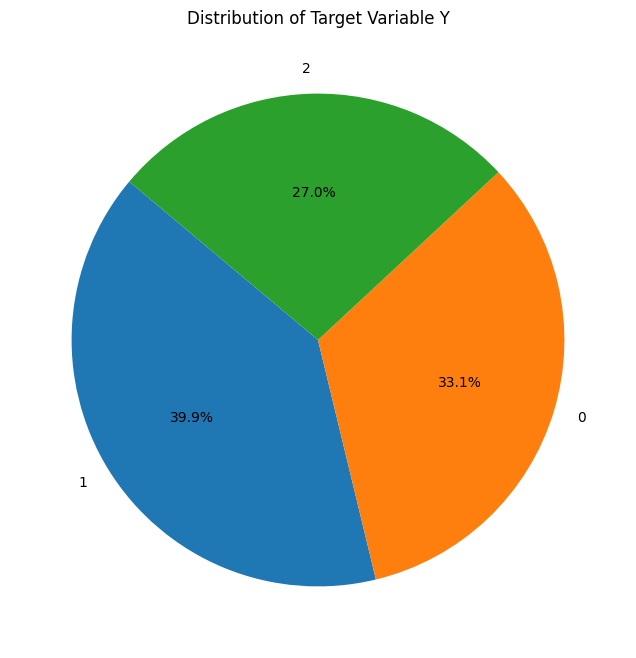

In [140]:
# Get the counts of each unique value in the 'Y' column
y_counts = df['Y'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(y_counts, labels=y_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Target Variable Y')
plt.show()

The pie chart illustrates the distribution of the target variable Y, representing the three wine classes. Class 1 dominates the dataset with 39.9%, followed by class 0 at 33.1%, and class 2 at 27.0%. This indicates a relatively balanced dataset, meaning that each class has a sufficient number of samples to train a classification model effectively. Because there is no major imbalance between classes, the model is less likely to be biased toward any particular class, allowing for fair and accurate learning of the distinguishing characteristics among the different wine types.

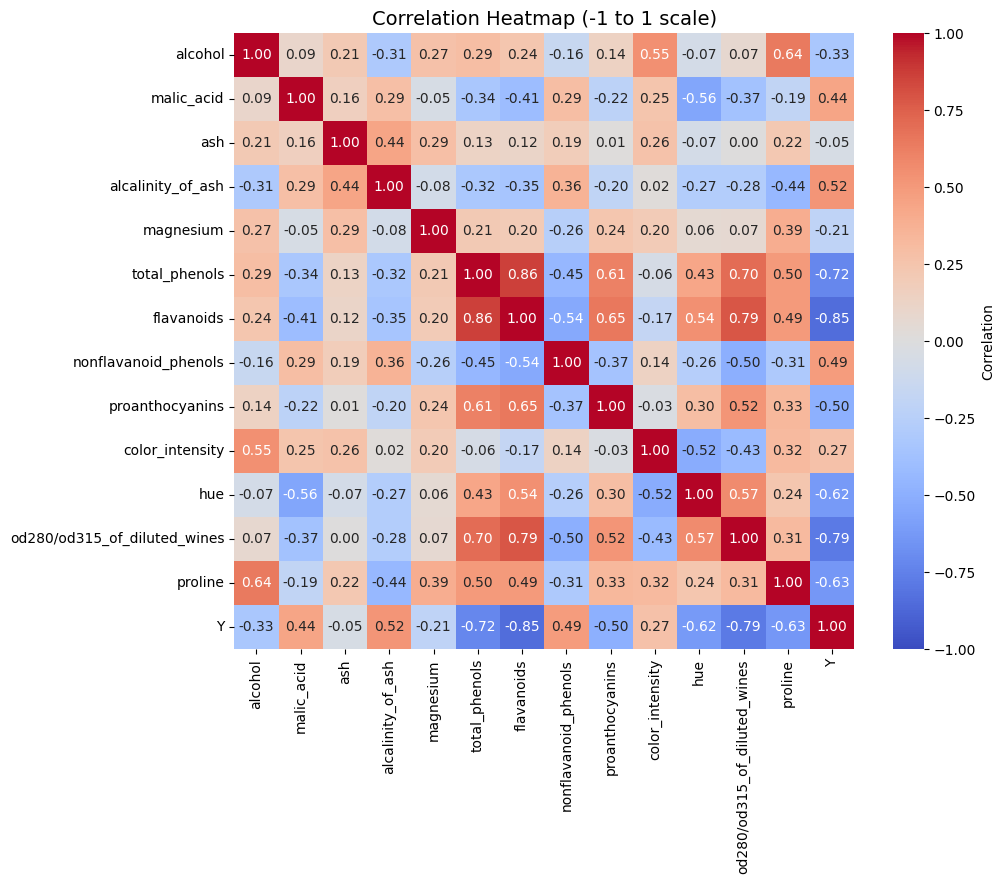

In [141]:
plt.figure(figsize=(10,8))

# Compute correlation (values from -1 to 1)
corr_matrix = df.corr()

# Plot heatmap with annotation
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',      # show two decimal places
    vmin=-1, vmax=1,   # force range between -1 and 1
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation Heatmap (-1 to 1 scale)", fontsize=14)
plt.show()


The correlation heatmap reveals that several wine chemical properties are strongly interrelated, notably flavanoids, total_phenols, and od280/od315_of_diluted_wines, which exhibit high positive correlations above 0.75, indicating they measure similar aspects of wine composition. The target variable Y shows strong negative correlations with flavanoids (–0.85) and od280/od315_of_diluted_wines (–0.79), meaning higher values of these features are associated with lower wine class labels, while malic_acid (0.44) correlates positively, suggesting higher acid levels in higher-class wines. Overall, the matrix highlights clear linear relationships that can effectively help classification algorithms like PRISM distinguish between wine types based on their chemical attributes.

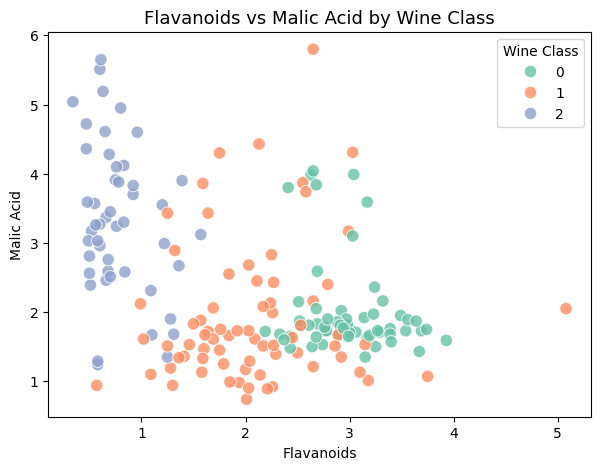

In [142]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x='flavanoids',
    y='malic_acid',
    hue='Y',
    palette='Set2',
    s=80,
    alpha=0.8
)
plt.title("Flavanoids vs Malic Acid by Wine Class", fontsize=13)
plt.xlabel("Flavanoids")
plt.ylabel("Malic Acid")
plt.legend(title='Wine Class')
plt.show()

The scatter plot illustrates a clear inverse relationship between flavanoids and malic acid across the three wine classes. Wines with higher flavanoid content generally have lower malic acid levels, while those with low flavanoids tend to show high malic acid values. This pattern highlights a chemical trade-off between the two compounds, where Class 0 wines cluster around high flavanoids and low malic acid, Class 2 wines group around low flavanoids and high malic acid, and Class 1 wines occupy the middle range. The distinct clustering of colors suggests that these two variables are strong discriminators for identifying different wine classes.

# Generate Rules with PRISM

In [143]:
# since we dont do any partitioning bcs we have to use both X and Y in our 'prism' model, so let's just use 100 rows for this training and the rest for the testing

# PRISM requires all columns be categorical, so bin any numeric features, including the target column if necessary, BUT there's a binning function in 'get_prism_rules', so we dont need to binning it manually first.

prism = PrismRules()
_ = prism.get_prism_rules(df.head(100), 'Y')


........................................................................
Target: 1
........................................................................
alcohol = Low AND color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 28 rows matching the rule 
   Coverage: the rule matches: 28 out of 39 rows for target value: '1'. This is:
      71.795% of total rows for target value: '1'
      28.000% of total rows in data

........................................................................
Target: 2
........................................................................
flavanoids = Low AND hue = Low
   Support:  the target has value: '2' for 100.000% of the 23 rows matching the rule 
   Coverage: the rule matches: 23 out of 26 rows for target value: '2'. This is:
      88.462% of total rows for target value: '2'
      23.000% of total rows in data

........................................................................
Target: 0
.........................

🔹 Rule 1

“If alcohol is Low and color_intensity is Low → class 1,
meaning wines with lower alcohol levels and lighter color intensity tend to belong to class 1.”

🔹 Rule 2

“If flavanoids are Low and hue is Low → class 2,
meaning wines with lower flavanoid content and duller hue values tend to belong to class 2.”

🔹 Rule 3

“If proline is High and alcohol is High → class 0,
meaning wines that are rich in proline and have higher alcohol concentration tend to belong to class 0.”

### 🔹 **Rule 1:**

**Rule:** `alcohol = Low AND color_intensity = Low → Class 1`

**Meaning:**
This rule indicates that wines with **low alcohol content** and **light color intensity** are most likely to belong to **class 1**. Chemically, this suggests that class 1 wines are lighter-bodied, less concentrated, and possibly less mature, with both their alcohol strength and pigmentation at the lower end of the spectrum. These wines are milder and more delicate in composition compared to the other types.

**Class Represented:**
Class **1**

**Strength (Support & Coverage):**

* **Support:** 100% — every wine matching this rule truly belongs to class 1, meaning **the rule is perfectly specific** (no misclassifications).
* **Coverage:** 71.8% — the rule covers about **72% of all class 1 wines**, making it a **broad and strong descriptor** of the typical characteristics of this class.

---

### 🔹 **Rule 2:**

**Rule:** `flavanoids = Low AND hue = Low → Class 2`

**Meaning:**
This rule shows that wines with **low flavanoid levels** and **low hue values** (less vibrant or darker tone) are characteristic of **class 2**. These wines tend to have lower phenolic richness and weaker coloration, indicating they might be less aromatic and more acidic. This aligns with class 2’s chemical profile — wines that are less intense, possibly younger or less mature, with a simpler composition.

**Class Represented:**
Class **2**

**Strength (Support & Coverage):**

* **Support:** 100% — all 23 wines matching this rule belong to class 2, confirming **perfect precision**.
* **Coverage:** 88.5% — this rule captures **nearly nine-tenths** of all class 2 wines, making it **highly comprehensive** and a dominant defining rule for this class.


---

### 🔹 **Rule 3:**

**Rule:** `proline = High AND alcohol = High → Class 0`

**Meaning:**
This rule identifies that wines rich in **proline** (an amino acid linked to mature grape development and full flavor) and with **high alcohol content** are typical of **class 0**. These wines are likely to be more robust, full-bodied, and chemically complex, reflecting higher sugar conversion and phenolic maturity. They represent a stronger and richer wine profile compared to classes 1 and 2.

**Class Represented:**
Class **0**

**Strength (Support & Coverage):**

* **Support:** 100% — every one of the 26 wines covered by this rule is correctly classified as class 0, showing **perfect specificity**.
* **Coverage:** 74.3% — this rule explains nearly **three-fourths of all class 0 wines**, representing a large, clearly defined segment of the class.


---


 **Conclusion:**
All three PRISM rules show **perfect precision (100%)**, meaning the conditions they define are chemically distinct for each class.
Class 2’s rule provides the **widest coverage (88%)**, followed by class 0 (74%) and class 1 (72%), showing that the model successfully captured strong, interpretable relationships between chemical properties and wine categories.
In short:

* **Class 0** → rich and strong wines (high proline, high alcohol)
* **Class 1** → light-bodied wines (low alcohol, low color)
* **Class 2** → mild and acidic wines (low flavanoids, low hue)


# Bin Ranges Result

In [144]:
# This section only to know the range of the bins
bin_ranges_data = []
for col, ranges in prism.get_bin_ranges().items():
    counts, _ = np.histogram(df[col], bins=ranges)
    for i in range(len(ranges) - 1):
        bin_ranges_data.append({
            'Column': col,
            'Bin': i,
            'Lower Bound': ranges[i],
            'Upper Bound': ranges[i+1],
            'Bin': i,
            'Count': counts[i]
        })

bin_ranges_df = pd.DataFrame(bin_ranges_data)
display(bin_ranges_df)

,Column,Bin,Lower Bound,Upper Bound,Count
0,alcohol,0,11.03,12.53,60
1,alcohol,1,12.53,13.52,64
2,alcohol,2,13.52,14.83,54
3,malic_acid,0,0.74,1.61,45
4,malic_acid,1,1.61,2.15,62
5,malic_acid,2,2.15,5.51,69
6,ash,0,1.70,2.28,58
7,ash,1,2.28,2.45,52
8,ash,2,2.45,3.23,67
9,alcalinity_of_ash,0,11.40,18.00,51


# Test on Y Pred

In [145]:
# we use the rest of our data for testing, in this case is 36 rows
y_pred = prism.predict(df.tail(36).drop(columns=['Y']))
f1_score(df.tail(36)['Y'], y_pred, average=None)

array([0.82352941, 0.92682927, 1.        ])

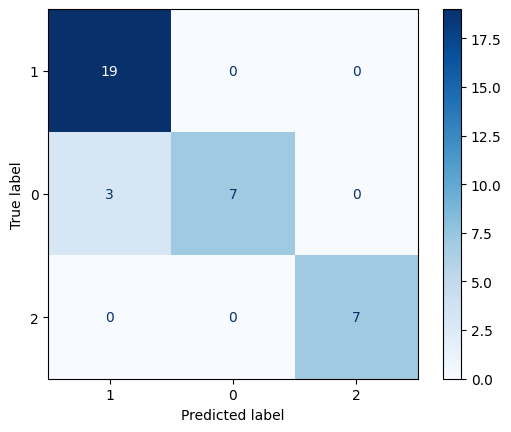

In [146]:
# We next display the confusion matrix.
labels = y_pred.unique()
cm = confusion_matrix(df.tail(36)['Y'], y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.show()

The confusion matrix shows that the PRISM model performed very accurately overall. Class 1 achieved perfect classification with 19 wines correctly predicted and no misclassifications, indicating strong rule precision for this group. Class 0 had 7 correct predictions but 3 misclassified as class 1, suggesting that some wines share overlapping traits with class 1, such as moderate alcohol or color intensity. Class 2 was classified perfectly with 7 correct predictions and no confusion with other classes, showing that its chemical characteristics are clearly distinct. Overall, the matrix demonstrates excellent predictive performance, with the model strongest for classes 1 and 2, and only minor overlap between classes 0 and 1.

In [147]:
# classification report
from sklearn.metrics import classification_report

print(classification_report(df.tail(36)['Y'], y_pred))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82        10
           1       0.86      1.00      0.93        19
           2       1.00      1.00      1.00         7

    accuracy                           0.92        36
   macro avg       0.95      0.90      0.92        36
weighted avg       0.93      0.92      0.91        36



The classification report shows that the **PRISM model achieved excellent performance** with an overall **accuracy of 92%** on the test data.

* **Class 0:** Precision is **1.00**, meaning every wine predicted as class 0 was correct, but recall is **0.70**, indicating the model identified only 70% of actual class 0 wines — it missed a few that were likely classified as class 1.
* **Class 1:** Shows **balanced and strong performance**, with precision **0.86**, recall **1.00**, and an F1-score of **0.93**, meaning nearly all true class 1 wines were correctly identified, though a few other classes were misclassified as class 1.
* **Class 2:** Achieved **perfect scores** across precision, recall, and F1-score (all 1.00), showing that the model flawlessly recognized this class with no misclassifications.

The **macro average F1-score of 0.92** and **weighted average F1-score of 0.91** indicate consistently high performance across all classes. Overall, the PRISM model demonstrates **high precision and strong generalization**, particularly excelling in identifying classes 1 and 2, with only a slight recall weakness for class 0.


In [150]:
# Create new data points for the Wine dataset
# You can change these values to test different scenarios
new_wine_data = {
    'alcohol': [14.0, 14.00],
    'malic_acid': [2.0, 2.0],
    'ash': [2.3, 2.2],
    'alcalinity_of_ash': [19.0, 11.0],
    'magnesium': [95.0, 95.0],
    'total_phenols': [2.2, 2.5],
    'flavanoids': [0.14, 0.5],
    'nonflavanoid_phenols': [0.14, 0.5],
    'proanthocyanins': [1.6, 1.5],
    'color_intensity': [7.0, 6.0],
    'hue': [0.7, 0.6],
    'od280/od315_of_diluted_wines': [3.2, 3.0],
    'proline': [550.0, 1400.0]
}

new_wine_df = pd.DataFrame(new_wine_data)

# Predict on the new Wine data using the prism model trained on Wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Iris Data Points:")
display(new_wine_df)

New Iris Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


### Sample 0  → **Predicted Class = 1**

* **Which rule matched?** **No explicit rule matched.**

  * It does **not** meet alcohol = Low AND color_intensity = Low(both are high),
  * It does **not** meet flavanoids = Low AND hue = Low (one or both may fall outside the **Low** bins used by PRISM),
  * It does **not** meet proline = High AND alcohol = High(alcohol may be **Medium** in PRISM’s quantile bins).
* **Why PRISM classifies it as class 1:**
  When no rule fires, PRISM returns the **default target** (the mode of the training labels), which in your model is **class 1**.
  *In sentence form:* **“No rule is satisfied → default to class 1, meaning this sample didn’t hit any learned conditions and is assigned to the most common class.”**

---

### Sample 1  → **Predicted Class = 2**

* **Which rule matched?**
  **“If flavanoids are Low and hue is Low → class 2,** meaning wines with lower flavanoid content and duller hue tend to belong to class 2.”
  (Your model’s stats: **Support = 100%**, **Coverage ≈ 88.5%** of class-2 wines.)
* **Why PRISM classifies it as class 2:**
  This sample has **flavanoids = 0.5 (Low)** and **hue = 0.6 (Low)**, satisfying the class-2 rule; once a rule fully matches, PRISM assigns that class regardless of other features (e.g., high proline or alcohol).


That's all. Thank you. Gbu